## Main Trading Bot Logic

The first algorithm we will test out is DQN. This is the de facto standard for single agent RL algorithms at this point. 

<img src="DQN.png" alt="drawing" width="700"/>

Before we actually start working on the core algorithm we are going to use for the trading bot, we should probably make sure we can pull the appropriate data and clean it if necessary. Perhaps the most obvious place to start is [Yahoo! Finance](https://finance.yahoo.com/).

We will set this up so we can run our algorithm with some input parameters like the ticker code for a stock/crypto and automate the cleaning and training process.

## Test on LunarLander

In [17]:
import gym
import numpy as np
import tensorflow as tf

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

In [ ]:
# state_dim defines the number of days to take in a
#TAU = 1e-3              # for soft update of target parameters
lunar_agent = agent.DQNAgent(
    state_dim=8,
    action_dim=4,
    hidden_layer_sizes=[64,64],
    buffer_size=10000,
    batch_size=64,
    discount=0.99,
    learning_rate=5e-4,
    learning_freq=4
)

In [ ]:
# Evaluate untrained model

state = env.reset()
for j in range(200):
    state = tf.reshape(state,shape=(1,-1))
    action = lunar_agent.act(state, evaluation=True)
    #env.render()
    state, reward, done, _ = env.step(action)
    print(reward)    
    if done:
        break 
#env.close()

In [ ]:
from collections import deque
import numpy as np 

def dqn(n_episodes=100, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        print(i_episode)
        state = env.reset()
        state = tf.reshape(state,shape=(1,-1))

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = tf.reshape(next_state,shape=(1,-1))
            lunar_agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=200.0:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        #     break
    return scores
dqn()

## Trading Agent

In [1]:
from SmartTradingBot import agent, utils
from SmartTradingBot.utils import get_data

In [39]:
train, test = get_data(['BTC-USD'], start_date="2019-01-01")

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

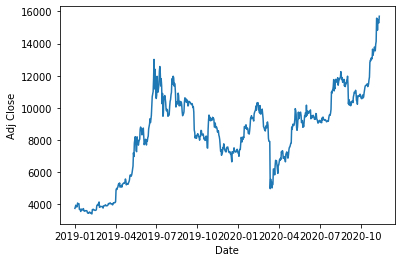

In [40]:
import seaborn as sns
sns.lineplot(train.index, train)

<AxesSubplot:xlabel='Date'>

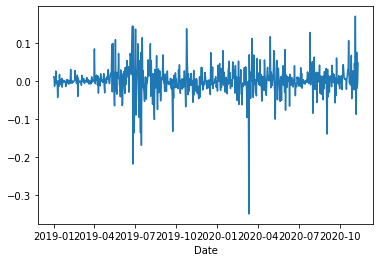

In [41]:
y = utils.normalised_difference(data=train)
sns.lineplot(train.index[:-1],y)

<AxesSubplot:xlabel='Date'>

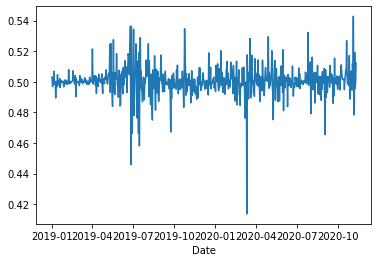

In [42]:
y = utils.sigmoid(y)
sns.lineplot(train.index[:-1],y)

In [43]:
trading_agent = agent.DQNAgent(
    state_dim=10, # 10 days data is one "state1"/feature
    action_dim=3, # [Hold,Buy,Sell] = [0,1,2]
    hidden_layer_sizes=[128, 256, 256, 128],
    buffer_size=1000,
    batch_size=32,
    discount=0.99,
    learning_rate=1e-3,
    learning_freq=4
)

In [47]:
import tqdm
import numpy as np
def train_bot(data, episode, n_episodes=50):
    total_reward = 0
    losses = []
    data_length = len(data) - 1

    trading_agent.inventory = []
    avg_loss = []

    data = utils.normalised_difference(data)
    state = utils.padded_window(data, timestep=0, window_size=10)
    #print(state)
    #print(type(state))

    for t in tqdm.tqdm(range(data_length), desc='Episode {}/{}'.format(episode, n_episodes)):        
        reward = 0
        next_state = utils.padded_window(data, timestep=t+1, window_size=10)
        action = trading_agent.act(state)

        # BUY
        if action == 1:
            trading_agent.inventory.append(data[t])

        # SELL
        elif action == 2 and len(trading_agent.inventory) > 0:
            bought_price = trading_agent.inventory.pop(0)
            delta = data[t] - bought_price
            reward = delta #max(delta, 0)
            total_reward += delta

        # HOLD
        else:
            pass

        done = (t == data_length - 1)
        loss = trading_agent.step(state, action, reward, next_state, done)
        if loss is not False:
            losses.append(loss)
        state = next_state

    #if episode % 10 == 0:
    #     trading_agent.save(episode)

    return (episode, n_episodes, total_reward, np.mean(np.array(avg_loss)))

In [45]:
n_episodes = 50
results=[]
for episode in range(1, n_episodes):
    x = train_bot(train, episode, n_episodes=n_episodes)
    results.append(x)

Episode 1/100:  14%|█▍        | 98/677 [00:24<02:25,  3.99it/s]


KeyboardInterrupt: 

In [46]:
results

[]